# ROC AUC
Assuming we have our data cleaned and our own models run with test dataset, the following codes only plot ROC curve and calculate AUC.

### Generating ROC Curve (my model)

Comment from Joe: I think this is basically the same as the line in
alternatives below

In [2]:
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score

def roc(myModel, y_true, testData):
    model_pred = myModel.decision_function(testData) #Why having this?
    RocCurveDisplay.from_predictions(y_true, model_pred)
    plt.show()
    return model_pred

### Alternative

```RocCurveDisplay.from_estimator(myModel, X, y)```

### Prediction Probabilities (my model & random prediction)

In [3]:
def pred_probs(myModel, testData):
    random_probs = [0] * len(testData)
    model_probs = myModel.predict_proba(testData)[:,1]
    return random_probs, model_probs

### Calculate AUC (compare with random prediction)

Comment from Joe: This is useful if we are looking only at one model, but may need to be tweaked to work with multiple models to avoid calculating the random score more times than needed. See the multiple model selection below.

In [4]:
def auc(testData, myProbs, modelPred, randomProbs):
    random_auc = roc_auc_score(testData, randomProbs)
    model_auc = roc_auc_score(testData, myProbs)
    model_pred_auc = roc_auc_score(testData, modelPred) #Why having this?
    print('Random (chance) Prediction: AUC = %.3f' % (random_auc))
    print('My Model: AUC = %.3f' % (model_auc))
    print('Model_pred: AUC = %.3f' % (model_pred_auc)) #Why having this?
    return random_auc, model_auc

### Calculate ROC Curve (my model and random prediction)

Comment from Joe: Same as above

In [5]:
def calulate_roc(testData, myProbs, randomProbs):
    my_fpr, my_tpr, _ = roc_curve(testData, myProbs)
    random_fpr, random_tpr, _ = roc_curve(testData, randomProbs)
    return my_fpr, my_tpr, random_fpr, random_tpr

### Plot the ROC Curve (compare with random prediction)

In [6]:
def roc_plot(myFPR, myTPR, myAUC, randomFPR, randomTPR, randomAUC):
    plt.plot(myFPR, myTPR, label = 'My model (AUC = %0.3f)' % myAUC)
    plt.plot(randomFPR, randomTPR, label = 'Random Prediction (AUC = %0.3f)' % randomAUC)
    
    #Title
    plt.title("ROC Plot")
    #Axis Labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #Show Legend
    plt.legend()
    #Show Plot
    plt.show()

### Plot multiple models on one graph

In [46]:
def get_roc_and_auc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    return fpr, tpr, auc

def plot_multiple_ROC(*models, y_true, X):
    rand_preds = [0] * len(y_true)
    rand_fpr, rand_tpr, rand_auc = get_roc_and_auc(y_true, rand_preds)
    plt.plot(rand_fpr, rand_tpr, '--', alpha = 0.4, label = f'Random Prediction (AUC = {rand_auc:0.2f})')
    
    aucs = {}
    for name, model in models:
        fpr, tpr, auc = get_roc_and_auc(y_true, model.predict_proba(X)[:,1])
        aucs[name] = auc
        plt.plot(fpr, tpr, alpha = 0.4, label = f'{name} (AUC = {auc:0.3f})')
    
    plt.title("ROC Plot")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    return aucs

## Example

In [7]:
import pandas as pd

# Classifiers
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Create generic dataset for classification
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold

# To compare models
from matplotlib import pyplot as plt
from numpy import mean
from numpy import std
import random as rd
rd.seed(1708)

/home/joseph/anaconda3/envs/kdd/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
# Create dummy regression dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)

# Convert to pandas
X = pd.DataFrame(X)
y = pd.DataFrame(y)

#Rename column
y = y.rename(columns={0: 'target'})

# Split into validation set
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [9]:
models = {}
models['xgb'] = XGBClassifier(max_depth=1, verbosity=0, use_label_encoder=False)
models['xgb2'] = XGBClassifier(max_depth=5, learning_rate=.0001, verbosity=0, use_label_encoder=False)
models['knn'] = KNeighborsClassifier()
models['knn2'] = KNeighborsClassifier(n_neighbors=7, weights="distance")
models['cart'] = DecisionTreeClassifier()
models['bayes'] = GaussianNB()

for model in models.values():
    model.fit(X_train, y_train.values.ravel())

/home/joseph/anaconda3/envs/kdd/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [10]:
#Creating a temporary dataframe so we can see how each of our models performed
temp = pd.DataFrame(y_val)

# Get each model in the stacked model to see how they individually perform
for m in models.items():
        temp[m[0]] = m[1].predict(X_val)

In [11]:
# See how each of our models correlate with our target
# In most instances of running the program the stacked predictions should outperform any singular model
print("Correlations with target column")
print(temp.corr()['target'])

Correlations with target column
target    1.000000
xgb       0.770964
xgb2      0.668043
knn       0.830204
knn2      0.869783
cart      0.689313
bayes     0.750939
Name: target, dtype: float64


In [24]:
score = pd.DataFrame({"model":models.keys()})

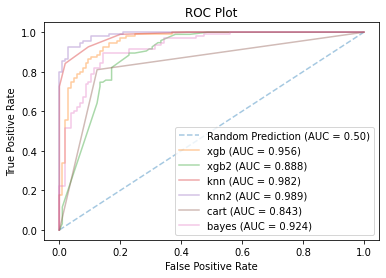

{'xgb': 0.9556892230576441,
 'xgb2': 0.8876190476190475,
 'knn': 0.9815037593984961,
 'knn2': 0.989172932330827,
 'cart': 0.8433583959899749,
 'bayes': 0.9235087719298245}

In [48]:
plot_multiple_ROC(*models.items(), y_true = y_val.target.values.ravel(), X = X_val)